# Image Clustering using ImageBind LLM Embeddings

## Assignment Part H

This notebook demonstrates image clustering using ImageBind, Meta's multimodal embedding model that can process images, text, audio, depth, thermal, and IMU data in a shared embedding space.

### What is ImageBind?
ImageBind is a revolutionary model from Meta AI that:
- Creates embeddings across 6 different modalities
- All modalities share the same embedding space
- Enables cross-modal retrieval and understanding
- Provides state-of-the-art performance for multimodal tasks

### Why ImageBind for Image Clustering?
- **Rich semantic embeddings**: Captures deep visual understanding
- **Pre-trained on massive datasets**: Transfer learning benefits
- **Multimodal capabilities**: Can relate images to text, audio, etc.
- **High-quality features**: Better than traditional CNN features

### Applications:
- Organizing photo libraries
- Content-based image retrieval
- Visual search engines
- E-commerce product categorization
- Medical image analysis

## 1. Installation and Setup

In [1]:
# Install required libraries
print("Installing ImageBind and dependencies...\n")

# Clone ImageBind repository
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind

# Install dependencies
!pip install -e . -q
!pip install ftfy regex tqdm -q
!pip install torchvision -q
!pip install Pillow -q

# Install clustering and visualization libraries
!pip install scikit-learn pandas numpy matplotlib seaborn -q
!pip install umap-learn -q
!pip install plotly -q

print("\nInstallation complete!")

Installing ImageBind and dependencies...

Cloning into 'ImageBind'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 187 (delta 84), reused 54 (delta 53), pack-reused 67 (from 3)
Receiving objects: 100% (187/187), 2.65 MiB | 12.69 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/ImageBind
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 26.5 MB/s eta 0:00:00

Installation complete!


In [2]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# ImageBind imports
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Clustering and evaluation
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
import umap

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print("Libraries imported successfully!")

Using device: cuda
Libraries imported successfully!


## 2. Load ImageBind Model

In [3]:
# Load pre-trained ImageBind model
print("Loading ImageBind model...\n")
print("This may take a few minutes on first run (downloading weights)...\n")

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")

Loading ImageBind model...

This may take a few minutes on first run (downloading weights)...



100%|██████████| 4.47G/4.47G [01:30<00:00, 53.2MB/s]


Model loaded successfully!
Model device: cuda:0


## 3. Load Image Dataset

We'll use a diverse set of images from different categories downloaded from the internet.

In [4]:
# Create a diverse image dataset from URLs
# Using Unsplash and other free image sources

image_urls = {
    # Animals - Dogs
    'dog_1': 'https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400',
    'dog_2': 'https://images.unsplash.com/photo-1552053831-71594a27632d?w=400',
    'dog_3': 'https://images.unsplash.com/photo-1583337130417-3346a1be7dee?w=400',

    # Animals - Cats
    'cat_1': 'https://images.unsplash.com/photo-1574158622682-e40e69881006?w=400',
    'cat_2': 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400',
    'cat_3': 'https://images.unsplash.com/photo-1570824104453-508955ab713e?w=400',

    # Nature - Beaches
    'beach_1': 'https://images.unsplash.com/photo-1507525428034-b723cf961d3e?w=400',
    'beach_2': 'https://images.unsplash.com/photo-1559827260-dc66d52bef19?w=400',
    'beach_3': 'https://images.unsplash.com/photo-1505142468610-359e7d316be0?w=400',

    # Nature - Mountains
    'mountain_1': 'https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=400',
    'mountain_2': 'https://images.unsplash.com/photo-1454496522488-7a8e488e8606?w=400',
    'mountain_3': 'https://images.unsplash.com/photo-1464822759023-fed622ff2c3b?w=400',

    # Urban - Cities
    'city_1': 'https://images.unsplash.com/photo-1480714378408-67cf0d13bc1b?w=400',
    'city_2': 'https://images.unsplash.com/photo-1449824913935-59a10b8d2000?w=400',
    'city_3': 'https://images.unsplash.com/photo-1514565131-fce0801e5785?w=400',

    # Food
    'food_1': 'https://images.unsplash.com/photo-1546069901-ba9599a7e63c?w=400',
    'food_2': 'https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=400',
    'food_3': 'https://images.unsplash.com/photo-1504674900247-0877df9cc836?w=400',

    # Vehicles - Cars
    'car_1': 'https://images.unsplash.com/photo-1552519507-da3b142c6e3d?w=400',
    'car_2': 'https://images.unsplash.com/photo-1542362567-b07e54a88780?w=400',
    'car_3': 'https://images.unsplash.com/photo-1583121274602-3e2820c69888?w=400',

    # Sports
    'sport_1': 'https://images.unsplash.com/photo-1461896836934-ffe607ba8211?w=400',
    'sport_2': 'https://images.unsplash.com/photo-1517649763962-0c623066013b?w=400',
    'sport_3': 'https://images.unsplash.com/photo-1471295253337-3ceaaedca402?w=400',
}

# Define true categories
true_categories = {
    'dog_1': 'Animals-Dogs', 'dog_2': 'Animals-Dogs', 'dog_3': 'Animals-Dogs',
    'cat_1': 'Animals-Cats', 'cat_2': 'Animals-Cats', 'cat_3': 'Animals-Cats',
    'beach_1': 'Nature-Beach', 'beach_2': 'Nature-Beach', 'beach_3': 'Nature-Beach',
    'mountain_1': 'Nature-Mountain', 'mountain_2': 'Nature-Mountain', 'mountain_3': 'Nature-Mountain',
    'city_1': 'Urban', 'city_2': 'Urban', 'city_3': 'Urban',
    'food_1': 'Food', 'food_2': 'Food', 'food_3': 'Food',
    'car_1': 'Vehicles', 'car_2': 'Vehicles', 'car_3': 'Vehicles',
    'sport_1': 'Sports', 'sport_2': 'Sports', 'sport_3': 'Sports',
}

print(f"Prepared {len(image_urls)} image URLs across {len(set(true_categories.values()))} categories")
print(f"\nCategories: {sorted(set(true_categories.values()))}")

Prepared 24 image URLs across 8 categories

Categories: ['Animals-Cats', 'Animals-Dogs', 'Food', 'Nature-Beach', 'Nature-Mountain', 'Sports', 'Urban', 'Vehicles']


In [5]:
# Download and prepare images
print("Downloading images...\n")

images = {}
failed_downloads = []

for name, url in image_urls.items():
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content)).convert('RGB')
            images[name] = img
            print(f"✓ {name}")
        else:
            print(f"✗ {name} (HTTP {response.status_code})")
            failed_downloads.append(name)
    except Exception as e:
        print(f"✗ {name} ({str(e)[:50]})")
        failed_downloads.append(name)

print(f"\n✓ Successfully downloaded {len(images)}/{len(image_urls)} images")

if failed_downloads:
    print(f"Failed: {', '.join(failed_downloads)}")


✓ dog_1
✓ dog_2
✓ dog_3
✓ cat_1
✓ cat_2
✓ cat_3
✓ beach_1
✓ beach_2
✓ beach_3
✓ mountain_1
✓ mountain_2
✓ mountain_3
✓ city_1
✓ city_2
✓ city_3
✓ food_1
✓ food_2
✓ food_3
✓ car_1
✗ car_2 (HTTP 404)
✓ car_3
✓ sport_1
✓ sport_2
✓ sport_3

✓ Successfully downloaded 23/24 images
Failed: car_2


Sample images from dataset:



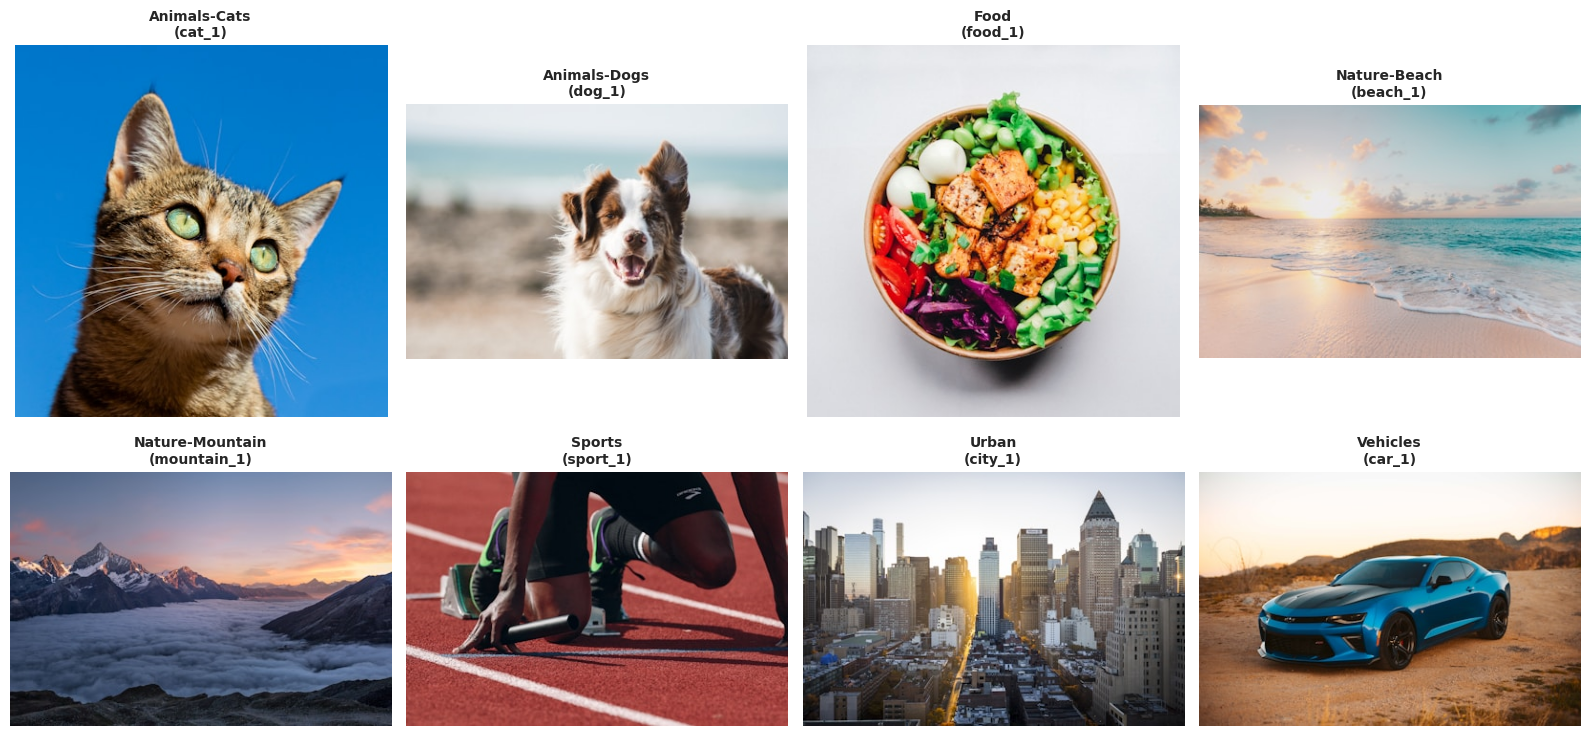

In [6]:
# Visualize sample images from each category
print("Sample images from dataset:\n")

# Get one image per category
categories = sorted(set(true_categories.values()))
sample_images = {}

for category in categories:
    for name, cat in true_categories.items():
        if cat == category and name in images:
            sample_images[category] = (name, images[name])
            break

# Plot samples
n_samples = len(sample_images)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (category, (name, img)) in enumerate(sample_images.items()):
    if idx < len(axes):
        axes[idx].imshow(img)
        axes[idx].set_title(f"{category}\n({name})", fontsize=10, fontweight='bold')
        axes[idx].axis('off')

# Hide unused subplots
for idx in range(len(sample_images), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 4. Generate Image Embeddings with ImageBind

In [7]:
# Save images temporarily for ImageBind processing
import os
import tempfile

temp_dir = tempfile.mkdtemp()
image_paths = []
image_names = []

for name, img in images.items():
    img_path = os.path.join(temp_dir, f"{name}.jpg")
    img.save(img_path)
    image_paths.append(img_path)
    image_names.append(name)

print(f"Saved {len(image_paths)} images to temporary directory")
print(f"Temp directory: {temp_dir}")

Saved 23 images to temporary directory
Temp directory: /tmp/tmpga83_ull


In [8]:
# Generate embeddings using ImageBind
print("Generating ImageBind embeddings...\n")
print("This may take a minute...\n")

# Load images for ImageBind
inputs = {
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device)
}

# Generate embeddings
with torch.no_grad():
    embeddings_dict = model(inputs)

# Extract vision embeddings
embeddings = embeddings_dict[ModalityType.VISION].cpu().numpy()

print(f"✓ Generated embeddings successfully!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"(Number of images: {embeddings.shape[0]}, Embedding dimension: {embeddings.shape[1]})")

# Create DataFrame
df_images = pd.DataFrame({
    'name': image_names,
    'category': [true_categories[name] for name in image_names]
})

print(f"\nDataset info:")
display(df_images.head())
print(f"\nCategory distribution:")
print(df_images['category'].value_counts())

Generating ImageBind embeddings...

This may take a minute...

✓ Generated embeddings successfully!
Embeddings shape: (23, 1024)
(Number of images: 23, Embedding dimension: 1024)

Dataset info:


name      category
0  dog_1  Animals-Dogs
1  dog_2  Animals-Dogs
2  dog_3  Animals-Dogs
3  cat_1  Animals-Cats
4  cat_2  Animals-Cats


Category distribution:
category
Animals-Dogs       3
Animals-Cats       3
Nature-Beach       3
Nature-Mountain    3
Urban              3
Food               3
Sports             3
Vehicles           2
Name: count, dtype: int64


## 5. Visualize Embeddings

In [10]:
# Reduce dimensions for visualization
print("Reducing dimensions for visualization...\n")

# PCA
pca_n_components = min(50, len(embeddings) - 1) # Ensure n_components <= n_samples - 1
pca = PCA(n_components=pca_n_components, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(embeddings)-1))
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# UMAP
print("Applying UMAP...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=min(5, len(embeddings)-1))
embeddings_umap = umap_reducer.fit_transform(embeddings)

print("\n✓ Dimensionality reduction complete!")

Reducing dimensions for visualization...

PCA explained variance: 100.00%
Applying t-SNE...
Applying UMAP...

✓ Dimensionality reduction complete!


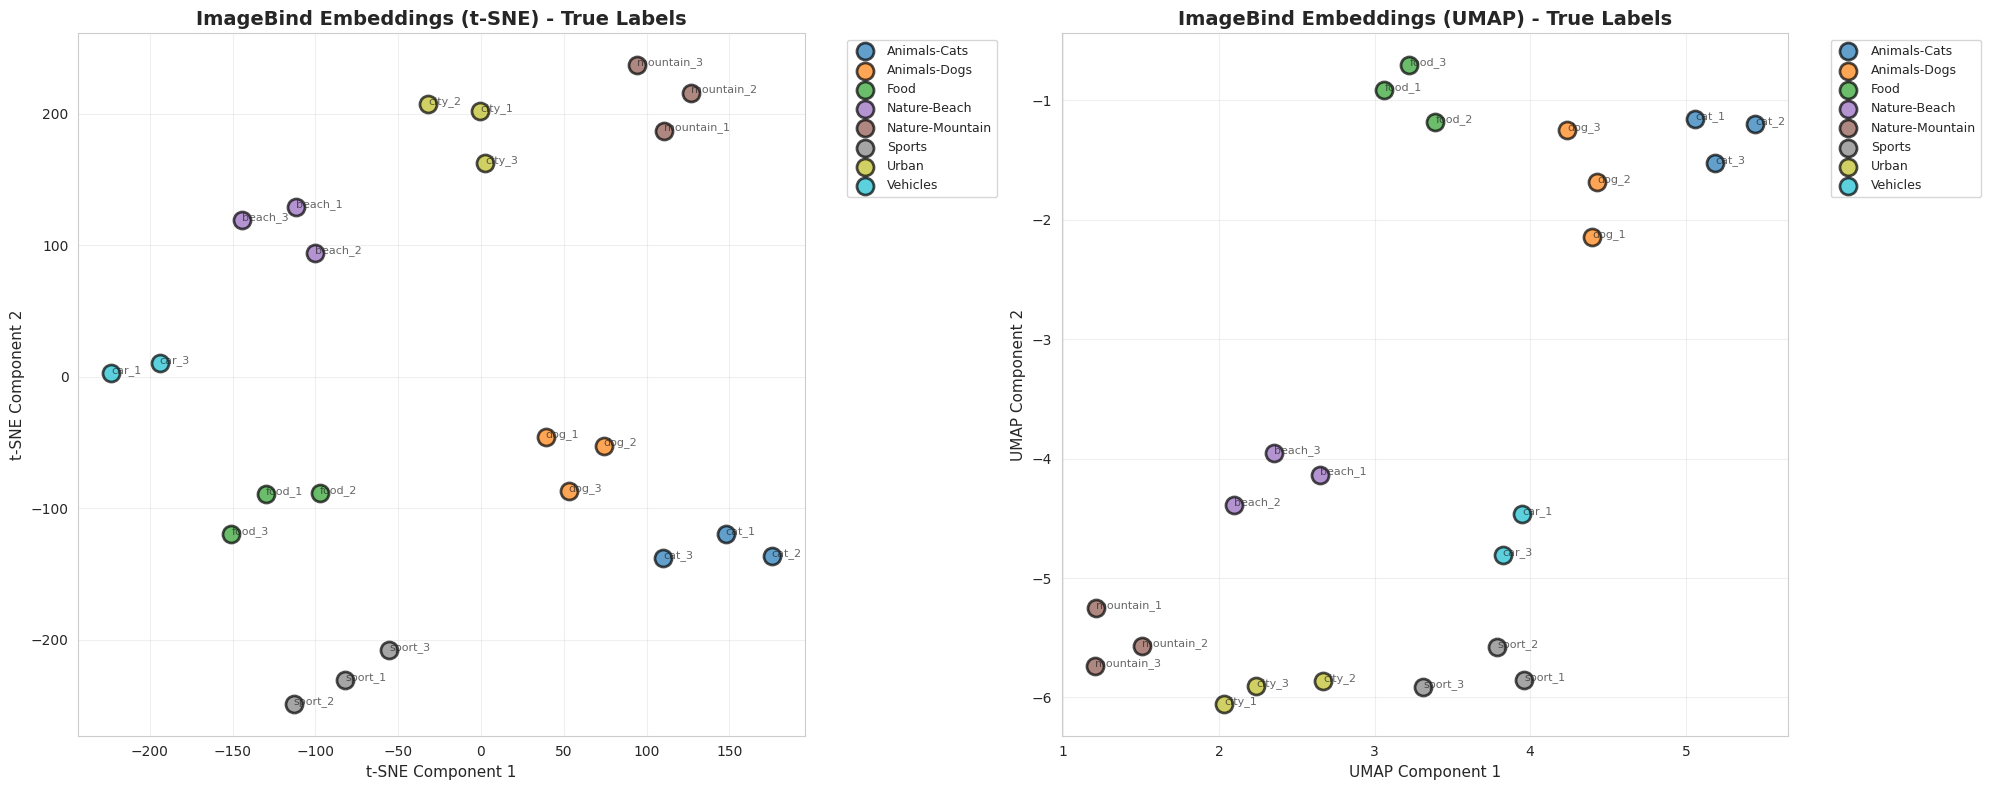

In [11]:
# Visualize embeddings with true labels
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create color map for categories
unique_categories = sorted(df_images['category'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_categories)))
category_colors = {cat: colors[i] for i, cat in enumerate(unique_categories)}

# t-SNE plot
for category in unique_categories:
    mask = df_images['category'] == category
    axes[0].scatter(
        embeddings_tsne[mask, 0],
        embeddings_tsne[mask, 1],
        c=[category_colors[category]],
        label=category,
        s=150,
        alpha=0.7,
        edgecolors='black',
        linewidth=2
    )

    # Add labels
    for idx in df_images[mask].index:
        axes[0].annotate(
            df_images.loc[idx, 'name'],
            (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
            fontsize=8,
            alpha=0.7
        )

axes[0].set_title('ImageBind Embeddings (t-SNE) - True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# UMAP plot
for category in unique_categories:
    mask = df_images['category'] == category
    axes[1].scatter(
        embeddings_umap[mask, 0],
        embeddings_umap[mask, 1],
        c=[category_colors[category]],
        label=category,
        s=150,
        alpha=0.7,
        edgecolors='black',
        linewidth=2
    )

    # Add labels
    for idx in df_images[mask].index:
        axes[1].annotate(
            df_images.loc[idx, 'name'],
            (embeddings_umap[idx, 0], embeddings_umap[idx, 1]),
            fontsize=8,
            alpha=0.7
        )

axes[1].set_title('ImageBind Embeddings (UMAP) - True Labels', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Image Clustering

In [12]:
# K-Means clustering
n_clusters = len(unique_categories)  # Use same number as true categories

print(f"Performing K-Means clustering with {n_clusters} clusters...\n")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Add cluster labels to dataframe
df_images['cluster'] = cluster_labels

print("Clustering complete!\n")
print("Cluster distribution:")
print(df_images['cluster'].value_counts().sort_index())

Performing K-Means clustering with 8 clusters...

Clustering complete!

Cluster distribution:
cluster
0    3
1    3
2    3
3    3
4    3
5    3
6    2
7    3
Name: count, dtype: int64


In [13]:
# Evaluate clustering quality
print("Clustering Quality Metrics")
print("="*80)

if len(np.unique(cluster_labels)) > 1:
    silhouette = silhouette_score(embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)

    print(f"\nSilhouette Score: {silhouette:.4f}")
    print("  → Range: [-1, 1], Higher is better")
    print("  → Interpretation: How well-separated the clusters are")

    print(f"\nDavies-Bouldin Index: {davies_bouldin:.4f}")
    print("  → Range: [0, ∞], Lower is better")
    print("  → Interpretation: Average similarity between clusters")

    print(f"\nCalinski-Harabasz Score: {calinski_harabasz:.4f}")
    print("  → Range: [0, ∞], Higher is better")
    print("  → Interpretation: Ratio of between-cluster to within-cluster dispersion")

    print("\n" + "="*80)

    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
        'Value': [silhouette, davies_bouldin, calinski_harabasz],
        'Interpretation': ['Higher is better', 'Lower is better', 'Higher is better']
    })

    print("\nMetrics Summary:")
    display(metrics_df)
else:
    print("Only one cluster found. Metrics cannot be calculated.")

Clustering Quality Metrics

Silhouette Score: 0.1677
  → Range: [-1, 1], Higher is better
  → Interpretation: How well-separated the clusters are

Davies-Bouldin Index: 1.3171
  → Range: [0, ∞], Lower is better
  → Interpretation: Average similarity between clusters

Calinski-Harabasz Score: 2.8727
  → Range: [0, ∞], Higher is better
  → Interpretation: Ratio of between-cluster to within-cluster dispersion


Metrics Summary:


Metric     Value    Interpretation
0         Silhouette Score  0.167675  Higher is better
1     Davies-Bouldin Index  1.317120   Lower is better
2  Calinski-Harabasz Score  2.872705  Higher is better

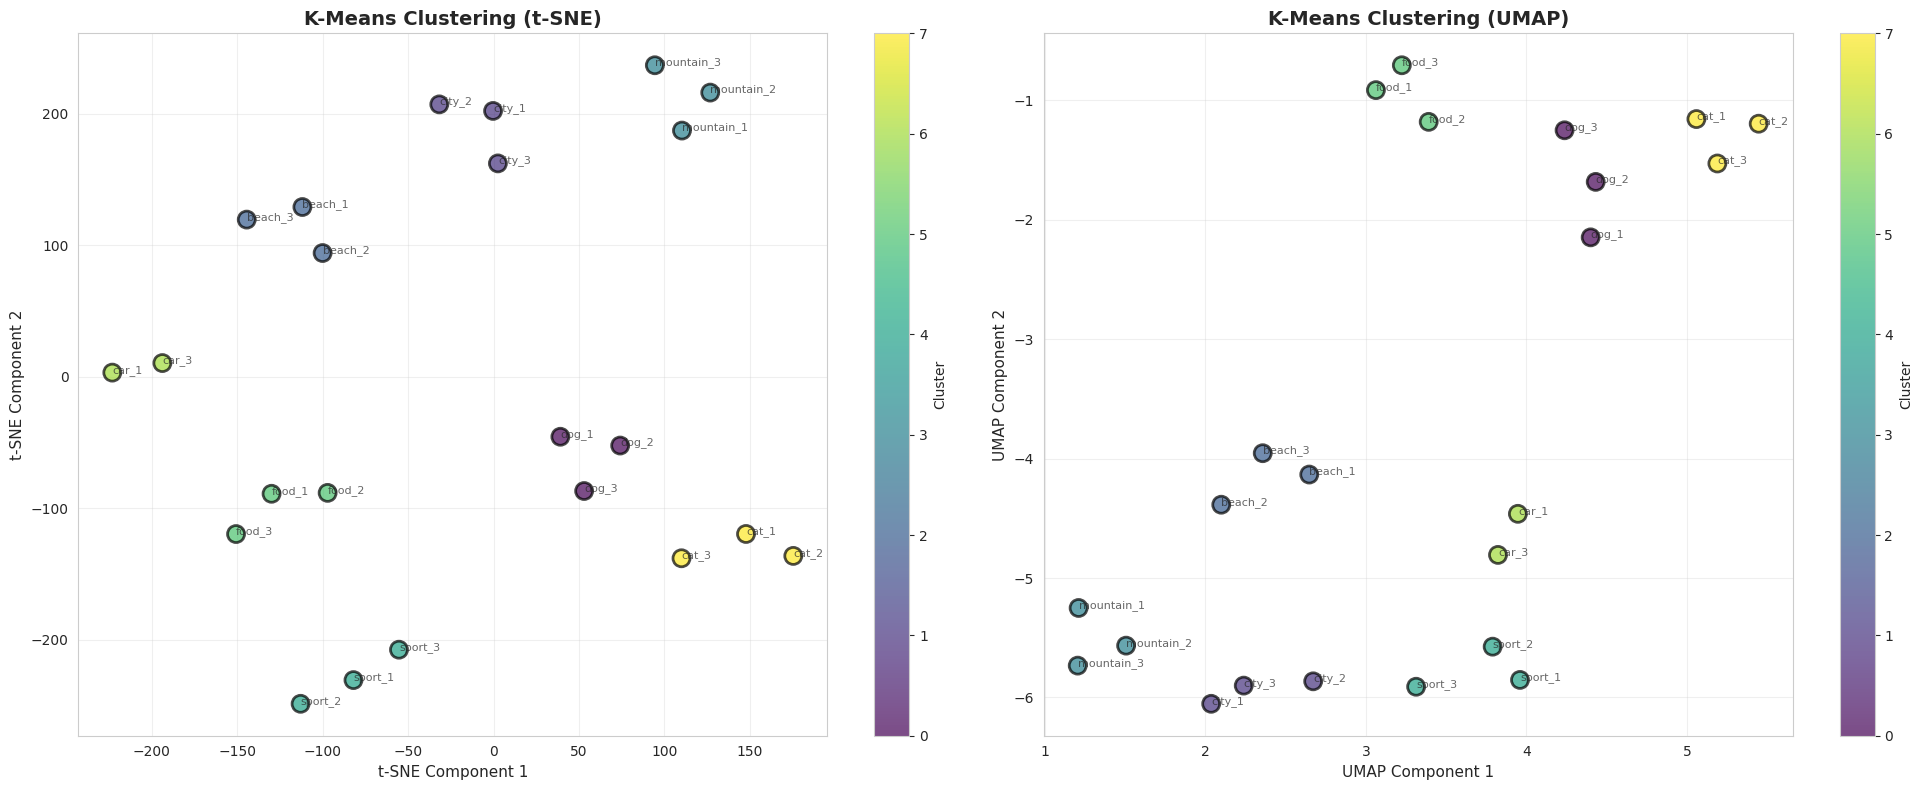

In [14]:
# Visualize clustering results
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# t-SNE with cluster labels
scatter1 = axes[0].scatter(
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=150,
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

# Add labels
for idx, name in enumerate(df_images['name']):
    axes[0].annotate(
        name,
        (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
        fontsize=8,
        alpha=0.7
    )

axes[0].set_title('K-Means Clustering (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=11)
axes[0].set_ylabel('t-SNE Component 2', fontsize=11)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# UMAP with cluster labels
scatter2 = axes[1].scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=150,
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

# Add labels
for idx, name in enumerate(df_images['name']):
    axes[1].annotate(
        name,
        (embeddings_umap[idx, 0], embeddings_umap[idx, 1]),
        fontsize=8,
        alpha=0.7
    )

axes[1].set_title('K-Means Clustering (UMAP)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Component 1', fontsize=11)
axes[1].set_ylabel('UMAP Component 2', fontsize=11)
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Cluster Analysis

In [15]:
# Analyze each cluster
print("Cluster Analysis")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_images = df_images[df_images['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id}:")
    print("-" * 80)
    print(f"Size: {len(cluster_images)} images")

    # Show true category distribution
    print(f"\nTrue category distribution:")
    category_dist = cluster_images['category'].value_counts()
    for category, count in category_dist.items():
        percentage = (count / len(cluster_images)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")

    # Show images in cluster
    print(f"\nImages in Cluster {cluster_id}:")
    for idx, row in cluster_images.iterrows():
        print(f"  - {row['name']} (True: {row['category']})")

    print("-" * 80)

print("\n" + "="*80)

Cluster Analysis

Cluster 0:
--------------------------------------------------------------------------------
Size: 3 images

True category distribution:
  Animals-Dogs: 3 (100.0%)

Images in Cluster 0:
  - dog_1 (True: Animals-Dogs)
  - dog_2 (True: Animals-Dogs)
  - dog_3 (True: Animals-Dogs)
--------------------------------------------------------------------------------

Cluster 1:
--------------------------------------------------------------------------------
Size: 3 images

True category distribution:
  Urban: 3 (100.0%)

Images in Cluster 1:
  - city_1 (True: Urban)
  - city_2 (True: Urban)
  - city_3 (True: Urban)
--------------------------------------------------------------------------------

Cluster 2:
--------------------------------------------------------------------------------
Size: 3 images

True category distribution:
  Nature-Beach: 3 (100.0%)

Images in Cluster 2:
  - beach_1 (True: Nature-Beach)
  - beach_2 (True: Nature-Beach)
  - beach_3 (True: Nature-Beach)
---


Cluster 0 Images:


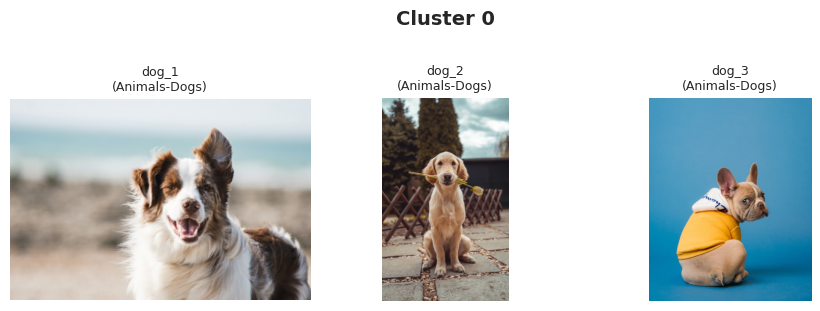


Cluster 1 Images:


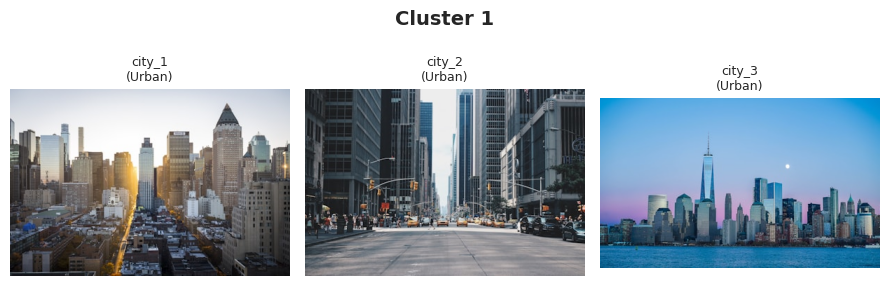


Cluster 2 Images:


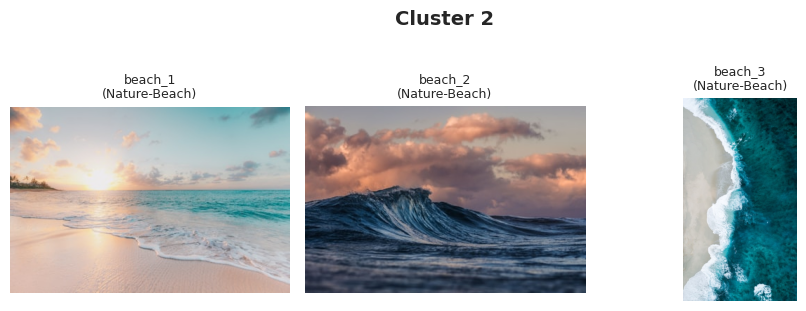


Cluster 3 Images:


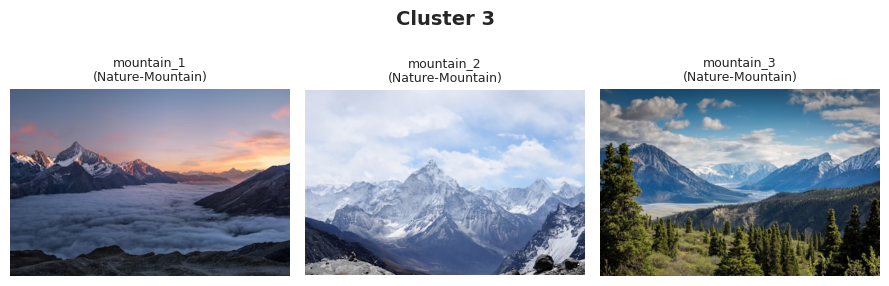


Cluster 4 Images:


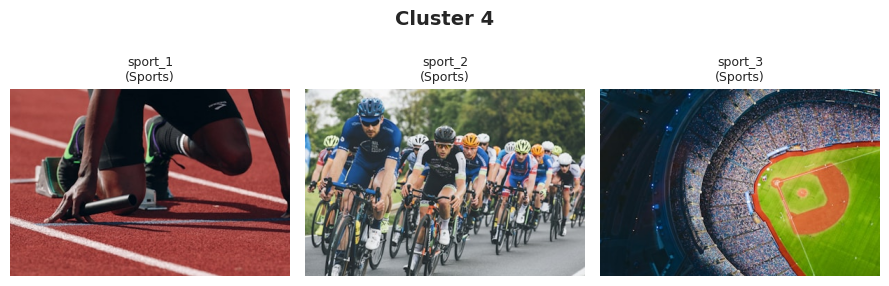


Cluster 5 Images:


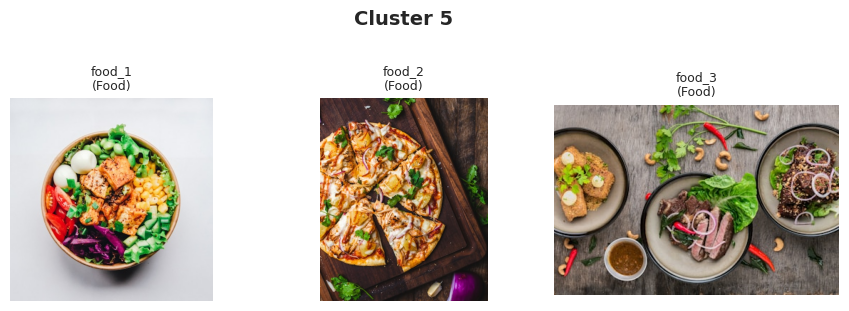


Cluster 6 Images:


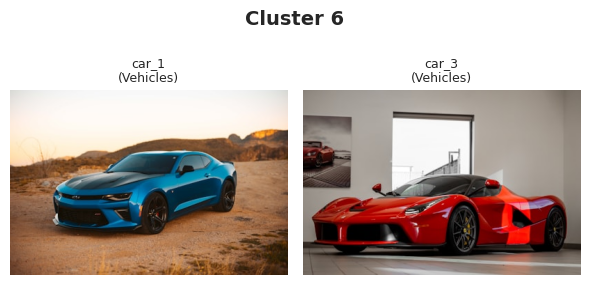


Cluster 7 Images:


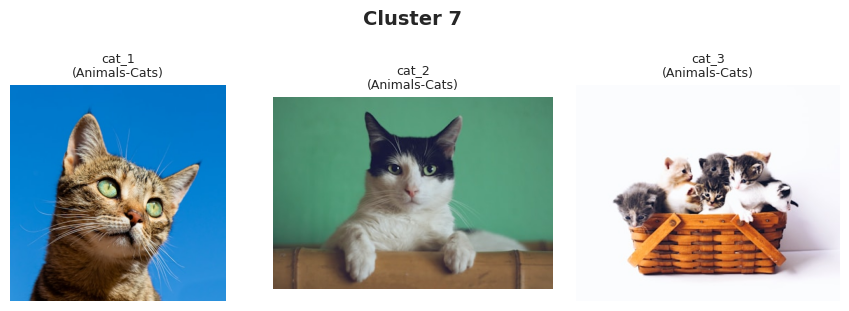

In [16]:
# Visualize images in each cluster
for cluster_id in range(n_clusters):
    cluster_images_names = df_images[df_images['cluster'] == cluster_id]['name'].tolist()

    if len(cluster_images_names) == 0:
        continue

    print(f"\nCluster {cluster_id} Images:")

    n_images = len(cluster_images_names)
    n_cols = min(5, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))

    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    for idx, img_name in enumerate(cluster_images_names):
        row = idx // n_cols
        col = idx % n_cols

        if img_name in images:
            axes[row, col].imshow(images[img_name])
            true_cat = true_categories[img_name]
            axes[row, col].set_title(f"{img_name}\n({true_cat})", fontsize=9)
            axes[row, col].axis('off')

    # Hide unused subplots
    for idx in range(len(cluster_images_names), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')

    plt.suptitle(f"Cluster {cluster_id}", fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


Contingency Table (Cluster vs True Category):


category  Animals-Cats  Animals-Dogs  Food  Nature-Beach  Nature-Mountain  \
cluster                                                                     
0                    0             3     0             0                0   
1                    0             0     0             0                0   
2                    0             0     0             3                0   
3                    0             0     0             0                3   
4                    0             0     0             0                0   
5                    0             0     3             0                0   
6                    0             0     0             0                0   
7                    3             0     0             0                0   
All                  3             3     3             3                3   

category  Sports  Urban  Vehicles  All  
cluster                                 
0              0      0         0    3  
1              0      3         0    3  
2              0      0         0    3  
3              0      0         0    3  
4              3      0         0    3  
5              0      0         0    3  
6              0      0         2    2  
7              0      0         0    3  
All            3      3         2   23

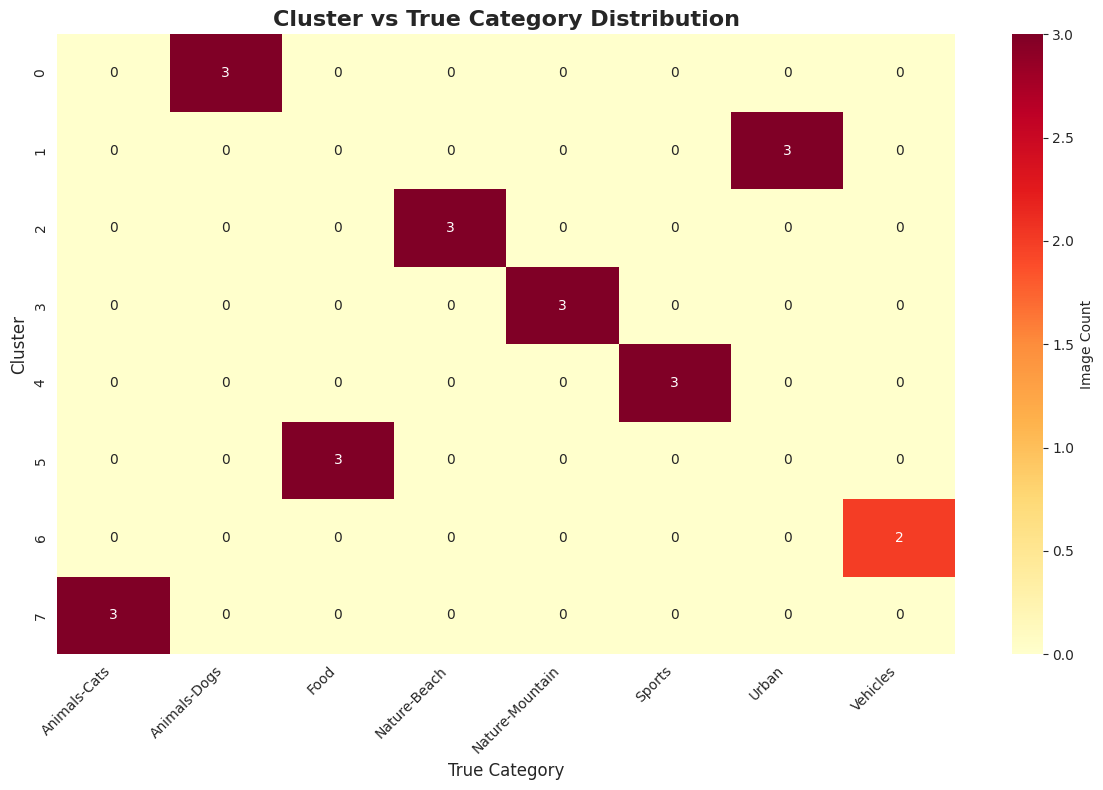

In [17]:
# Create confusion matrix between clusters and true categories
from sklearn.metrics import confusion_matrix

# Create contingency table
contingency_table = pd.crosstab(
    df_images['cluster'],
    df_images['category'],
    margins=True
)

print("\nContingency Table (Cluster vs True Category):")
print("="*80)
display(contingency_table)

# Visualize as heatmap
plt.figure(figsize=(12, 8))
contingency_no_margins = contingency_table.iloc[:-1, :-1]
sns.heatmap(contingency_no_margins, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Image Count'})
plt.title('Cluster vs True Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('True Category', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Alternative Clustering Methods

Performing Hierarchical clustering...



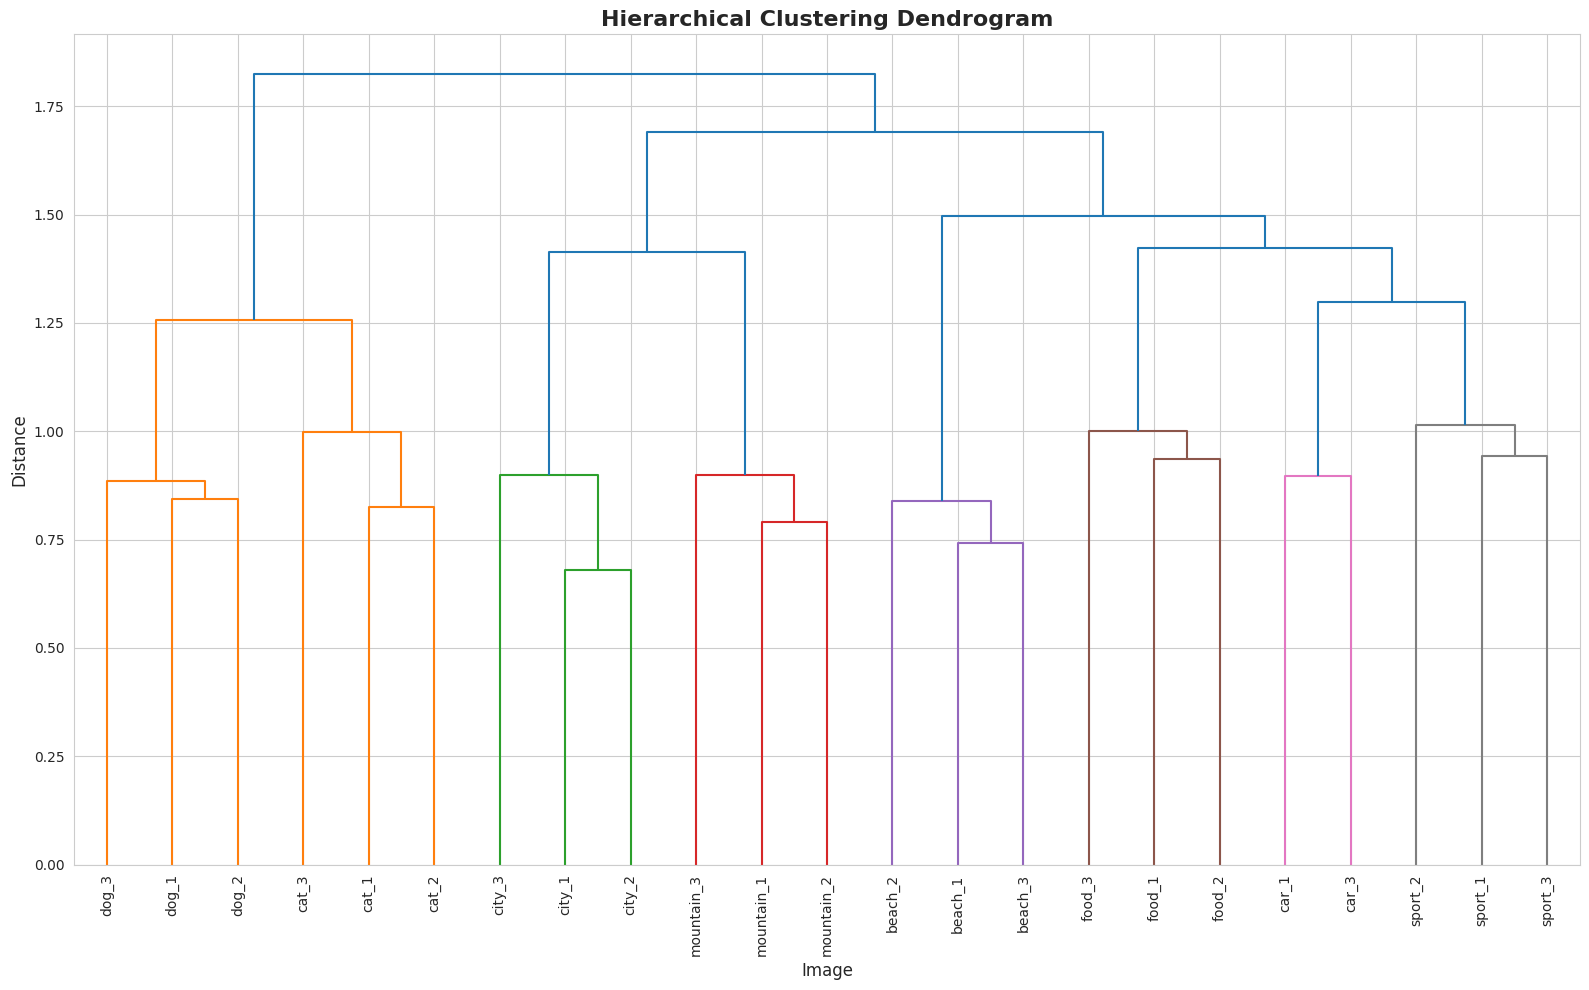


Hierarchical Cluster Assignments:

Cluster 0: (3 images)
  sport_1, sport_2, sport_3

Cluster 1: (3 images)
  food_1, food_2, food_3

Cluster 2: (3 images)
  mountain_1, mountain_2, mountain_3

Cluster 3: (3 images)
  dog_1, dog_2, dog_3

Cluster 4: (3 images)
  cat_1, cat_2, cat_3

Cluster 5: (3 images)
  city_1, city_2, city_3

Cluster 6: (2 images)
  car_1, car_3

Cluster 7: (3 images)
  beach_1, beach_2, beach_3


In [18]:
# Hierarchical clustering with dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

print("Performing Hierarchical clustering...\n")

linkage_matrix = linkage(embeddings, method='ward')

# Create dendrogram
plt.figure(figsize=(16, 10))
dendrogram(
    linkage_matrix,
    labels=df_images['name'].values,
    leaf_font_size=10,
    leaf_rotation=90
)
plt.title('Hierarchical Clustering Dendrogram', fontsize=16, fontweight='bold')
plt.xlabel('Image', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

# Apply hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(embeddings)

print("\nHierarchical Cluster Assignments:")
print("="*60)
for cluster_id in range(n_clusters):
    cluster_imgs = df_images['name'][hierarchical_labels == cluster_id].tolist()
    print(f"\nCluster {cluster_id}: ({len(cluster_imgs)} images)")
    print(f"  {', '.join(cluster_imgs)}")

## 9. Image Similarity Search

Find similar images using cosine similarity in the embedding space.

In [19]:
# Find similar images for each image
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Function to find top-k similar images
def find_similar_images(query_idx, k=3):
    similarities = similarity_matrix[query_idx]
    # Exclude the query image itself
    similar_indices = np.argsort(similarities)[::-1][1:k+1]
    return similar_indices, similarities[similar_indices]

# Example: Find similar images for first few images
print("Image Similarity Search Results:\n")
print("="*80)

for query_idx in range(min(5, len(df_images))):
    query_name = df_images.iloc[query_idx]['name']
    query_category = df_images.iloc[query_idx]['category']

    similar_indices, similarities = find_similar_images(query_idx, k=3)

    print(f"\nQuery: {query_name} ({query_category})")
    print("Top 3 most similar images:")
    for rank, (idx, sim) in enumerate(zip(similar_indices, similarities), 1):
        similar_name = df_images.iloc[idx]['name']
        similar_category = df_images.iloc[idx]['category']
        print(f"  {rank}. {similar_name} ({similar_category}) - Similarity: {sim:.4f}")
    print("-" * 80)

print("\n" + "="*80)

Image Similarity Search Results:


Query: dog_1 (Animals-Dogs)
Top 3 most similar images:
  1. dog_2 (Animals-Dogs) - Similarity: 0.6435
  2. dog_3 (Animals-Dogs) - Similarity: 0.6146
  3. beach_1 (Nature-Beach) - Similarity: 0.5736
--------------------------------------------------------------------------------

Query: dog_2 (Animals-Dogs)
Top 3 most similar images:
  1. dog_1 (Animals-Dogs) - Similarity: 0.6435
  2. dog_3 (Animals-Dogs) - Similarity: 0.6182
  3. cat_3 (Animals-Cats) - Similarity: 0.4766
--------------------------------------------------------------------------------

Query: dog_3 (Animals-Dogs)
Top 3 most similar images:
  1. dog_2 (Animals-Dogs) - Similarity: 0.6182
  2. dog_1 (Animals-Dogs) - Similarity: 0.6146
  3. cat_3 (Animals-Cats) - Similarity: 0.5191
--------------------------------------------------------------------------------

Query: cat_1 (Animals-Cats)
Top 3 most similar images:
  1. cat_2 (Animals-Cats) - Similarity: 0.6599
  2. cat_3 (Animals-Cats) -

## 10. Conclusion and Best Practices

### Key Findings:

#### 1. ImageBind for Image Clustering:
- **Advantages**:
  - State-of-the-art multimodal embeddings
  - Rich semantic understanding of images
  - Pre-trained on massive diverse datasets
  - Can relate images to other modalities (text, audio, etc.)
  - Single unified embedding space

- **Considerations**:
  - Requires significant computational resources (GPU recommended)
  - Large model size (download time on first use)
  - May be overkill for simple image clustering tasks

#### 2. ImageBind vs Traditional Methods:
- **ImageBind**: Better semantic understanding, cross-modal capabilities
- **ResNet/VGG**: Faster, lighter, still effective for many tasks
- **CLIP**: Good alternative, optimized for image-text

#### 3. Clustering Quality:
- ImageBind embeddings often result in semantically meaningful clusters
- Works well even with small datasets
- Can capture subtle visual similarities

### Best Practices:

#### 1. Data Preparation:
- Ensure consistent image formats (RGB)
- ImageBind handles resizing internally
- Remove corrupted or very low-quality images
- Consider image augmentation for robustness

#### 2. Embedding Generation:
- Use GPU for faster processing
- Process images in batches
- Cache embeddings to avoid recomputation
- Normalize embeddings if using certain distance metrics

#### 3. Clustering:
- Try multiple algorithms (K-Means, Hierarchical, DBSCAN)
- Use dimensionality reduction for visualization
- Validate with multiple metrics
- Consider domain knowledge in interpretation

#### 4. Evaluation:
- **Intrinsic metrics**: Silhouette, Davies-Bouldin, Calinski-Harabasz
- **Visual inspection**: Look at cluster contents
- **Similarity search**: Test if similar images are close in embedding space

### Practical Applications:

1. **Photo Organization**:
   - Automatically group photos by content
   - Find duplicate or similar images
   - Create smart albums

2. **E-commerce**:
   - Product categorization
   - Visual search ("find similar products")
   - Automated tagging

3. **Content Moderation**:
   - Group similar content
   - Detect near-duplicates
   - Identify outliers

4. **Medical Imaging**:
   - Group similar cases
   - Assist in diagnosis
   - Quality control

### Advanced Techniques:

1. **Cross-Modal Retrieval**:
   - Use ImageBind to find images matching text descriptions
   - Audio-to-image search
   - Multi-modal queries

2. **Fine-tuning**:
   - Adapt ImageBind to specific domains
   - Use domain-specific datasets
   - Metric learning approaches

3. **Ensemble Methods**:
   - Combine ImageBind with other models
   - Use multiple modalities
   - Weighted embeddings

### Performance Tips:

1. **Speed**:
   - Use GPU (CUDA)
   - Batch processing
   - Cache embeddings
   - Use mixed precision (FP16)

2. **Memory**:
   - Process large datasets in chunks
   - Clear cache between batches
   - Use CPU offloading if needed

3. **Quality**:
   - Use high-quality input images
   - Proper preprocessing
   - Ensemble different models

### Next Steps:

1. Try cross-modal retrieval (text-to-image)
2. Experiment with different clustering algorithms
3. Fine-tune on domain-specific data
4. Build an interactive search interface
5. Explore other ImageBind modalities